In [38]:
# %matplotlib inline
import sys
sys.path.append('./features')

from combineData import get_final_data
import matplotlib.pyplot as plt

from preprocess1 import get_all_data,preprocess
from pcvr2 import get_cache_pcvr
from userFeatures import get_cache_user_features
from brandFeatures  import get_cache_brand_features
from itemFeatures import get_cache_item_features
from categoryFeatures import get_cache_category_features
from shopFeatures import get_cache_shop_features

from sklearn.metrics import log_loss

import lightgbm as lgb

import utils
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier

from scipy import sparse 
import numpy as np
import pandas as pd

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
data = get_final_data()

使用缓存数据...
共用390个特征


In [30]:
## 列出训练特征
features = []
# 广告相关的特征
features.extend(['item_id', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
            'item_collected_level', 'item_pv_level','item_category_1','item_category_2',])
# 用户相关的特征
features.extend(['user_gender_id', 'user_occupation_id','user_age_level', 'user_star_level',])
# 上下文相关的特征
features.extend(['context_page_id','context_timestamp_Hour','context_timestamp_weekday'])
# 店铺相关的特征
features.extend(['shop_id', 'shop_review_num_level', 'shop_star_level',
            'shop_review_positive_rate', 'shop_score_service', 'shop_score_delivery', 'shop_score_description',])
# pcvr特征
features.extend([
            'item_category_1_pcvr','item_category_1_C','item_category_1_I',
            'item_category_2_pcvr','item_category_2_C','item_category_2_I',
            'item_brand_id_pcvr','item_brand_id_C','item_brand_id_I',
            'item_city_id_pcvr','item_city_id_C','item_city_id_I',
            'item_price_level_pcvr','item_price_level_C','item_price_level_I',
            'item_sales_level_pcvr','item_sales_level_C','item_sales_level_I',
            'item_collected_level_pcvr','item_collected_level_C','item_collected_level_I',
            'item_pv_level_pcvr','item_pv_level_C','item_pv_level_I',
            'user_gender_id_pcvr','user_gender_id_C','user_gender_id_I',
            'user_age_level_pcvr','user_age_level_C','user_age_level_I',
            'user_occupation_id_pcvr','user_occupation_id_C','user_occupation_id_I',
            'user_star_level_pcvr','user_star_level_C','user_star_level_I',
            'context_timestamp_Hour_pcvr','context_timestamp_Hour_C','context_timestamp_Hour_I',
            'context_page_id_pcvr','context_page_id_C','context_page_id_I',
            'shop_review_num_level_pcvr','shop_review_num_level_C','shop_review_num_level_I',
            'shop_star_level_pcvr','shop_star_level_C','shop_star_level_I'])

features+=utils.load_pickle(utils.temp_data_path+"brand_feature_name.plk")
features+=utils.load_pickle(utils.temp_data_path+"shop_feature_name.plk")
features+=utils.load_pickle(utils.temp_data_path+"item_feature_name.plk")
features+=utils.load_pickle(utils.temp_data_path+"category_feature_name.plk")
# features+=utils.load_pickle(utils.temp_data_path+"user_feature_name.plk")

# features = [x for x in features if x.find('0d')==-1]
features = [x for x in features if x.find('1d')==-1]
features = [x for x in features if x.find('2d')==-1]
features = [x for x in features if x.find('3d')==-1]
features = [x for x in features if x.find('d_I')==-1]
features = [x for x in features if x.find('d_C')==-1]
# features = [x for x in features if x.find('user_id')==-1]
features = [x for x in features if x.find('_is_trade')==-1]


features = [x for x in features if x.find('item_id')==-1]
features = [x for x in features if x.find('user_id')==-1]

# features = [x for x in features if x!='item_id']
# features = [x for x in features if x!='item_brand_id_item_id_count']
# features = [x for x in features if x!='item_category_1_item_idcount_is_max']
# features = [x for x in features if x!='item_category_1_item_id_view_is_max']
# features = [x for x in features if x!='item_brand_id_item_idcount_is_max']
# features = [x for x in features if x!='item_brand_id_item_id_view_is_max']


# features = [x for x in features if x!='item_id_0d_pcvr']
# features = [x for x in features if x!='user_gender_id_item_id_0d_pcvr']

# features = [x for x in features if x!='user_age_level_item_id_0d_pcvr']

# features = [x for x in features if x!='user_occupation_id_item_id_0d_pcvr']

features = [x for x in features if x.find('shop_id')==-1]

# features = [x for x in features if x.find('shop_id_count')==-1]
len(features)

72

In [48]:
train,test = data[data['type']=='train'],data[data['type']=='valid']

# 2. process data  
ss = StandardScaler(with_mean=False)  
enc = OneHotEncoder()  
lbl = LabelEncoder()


## 类别特征
category_features = ['item_brand_id','item_city_id','item_category_1','item_category_2','context_timestamp_weekday',
         'context_timestamp_Hour','user_gender_id','user_occupation_id',
        ]

for i,feat in enumerate(category_features):
    temp = lbl.fit_transform(data[feat])
    enc.fit(temp.reshape(-1,1))
    x_train = enc.transform(lbl.transform(train[feat]).reshape(-1,1))
    x_test = enc.transform(lbl.transform(test[feat]).reshape(-1,1))
    if i == 0:
        X_train,X_test = x_train,x_test
    else:
        X_train,X_test= sparse.hstack((X_train,x_train)),sparse.hstack((X_test,x_test))
    
continueFeautures = [ x for x in features if x not in category_features]
X_train,X_test = sparse.hstack((X_train,train[continueFeautures])),sparse.hstack((X_test,test[continueFeautures]))
y_train = train['is_trade']

from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

ss.fit(X_train)
X_train,X_test = ss.transform(X_train),ss.transform(X_test)

In [49]:
np.max(X_train)

1941.86686477239

In [9]:
from sklearn.model_selection import learning_curve
class ModelLGB(object):
    def __init__(self,n_estimators=200):
        self.model = lgb.LGBMClassifier(objective='binary',
                                        metric='binary_logloss',
                                       num_leaves=512,
                                       max_depth=-1,
                                       learning_rate=0.1,
                                       n_estimators=1000,
#                                        class_weight='balanced',
                                       subsample=0.2,
                                       colsample_bytree=0.1,
                                       reg_alpha=150,
                                       reg_lambda=60,
                                       random_state=2008,
                                       n_jobs=-1,
                                       silent=False,
#                                        categorical_feature=[0,1,6,7,8,9,13,14]
                                       )

    def fit(self,X,y):
        self.model.fit(X,y)

    def predict(self,data):
        y_predict = self.model.predict_proba(data)[:,1]
        return y_predict
    
    def plot_learning_curve(self,X,y,train_sizes = np.linspace(.1,1.0,5)):
        sizes,error_train,error_cv = learning_curve(self.model,X,y,train_sizes=train_sizes)
        plt.plot(sizes,np.mean(error_train,axis=1),'-o')
        plt.hold(True)
        plt.plot(sizes,np.mean(error_cv,axis=1),'-o')
        return sizes,error_train,error_cv

In [ ]:
plot_learning_curve(model,X,y,train_sizes = np.linspace(.1,1.0,5)):
        sizes,error_train,error_cv = learning_curve(model,X,y,train_sizes=train_sizes)
        plt.plot(sizes,np.mean(error_train,axis=1),'-o')
        plt.hold(True)
        plt.plot(sizes,np.mean(error_cv,axis=1),'-o')
        return sizes,error_train,error_cv

In [34]:
np.max(X_test,axis=1)

<57421x1 sparse matrix of type '<class 'numpy.float64'>'
	with 57421 stored elements in COOrdinate format>

In [51]:
model = ModelLGB()
model.fit(X_train,y_train)
test['predicted_score'] = model.predict(X_test)
score = utils.score(test)
print("按时间分 score: %.6f" % score)
print("平均：%.4f" % test['predicted_score'].mean())

按时间分 score: 0.085826
平均：0.0183


/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
lr = LogisticRegression(penalty='l1',random_state=2008,C=1)  
lr.fit(X_train, y_train)  
test['predicted_score'] = lr.predict_proba(X_test)[:, 1]  
score = utils.score(test)
print("按时间分 score: %.6f" % score)
print("平均：%.4f" % test['predicted_score'].mean())

按时间分 score: 0.096294
平均：0.0188


/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
xgb = XGBClassifier(
    silent = 1,
    learning_rate =0.01,
    n_estimators=1282,
    max_depth=5,
    min_child_weight=7,
    gamma=0,
    subsample=0.7,
    colsample_bytree=0.7,
    objective= 'binary:logistic',
    scale_pos_weight=1,
    reg_alpha=0.001,
    seed=27)
xgb.fit(X_train,y_train)
test['predicted_score'] = xgb.predict_proba(X_test)[:, 1]  
score = utils.score(test)
print("按时间分 score: %.6f" % score)
print("平均：%.4f" % test['predicted_score'].mean())

按时间分 score: 0.109373
平均：0.0174


/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [13]:
data.loc[data['type']=='valid','is_trade'] = np.NaN

In [15]:
data.loc[data['type']=='test',['instance_id','is_trade']]

instance_id  is_trade
0      2475218615076601065       NaN
1       398316874173557226       NaN
2      6586402638209028583       NaN
3      1040996105851528465       NaN
4      6316278569655873454       NaN
5       868158305045921978       NaN
6      5713520501786699854       NaN
7       932945015407923184       NaN
8      1919197847086752313       NaN
9       304887065966615346       NaN
10        3282556850371665       NaN
11     8829646398295427742       NaN
12     3177704368658581090       NaN
13      331811904131229654       NaN
14     1529584165704680903       NaN
15      410957802501821801       NaN
16     7858701120525579871       NaN
17     1007593432911733192       NaN
18     6933421324008829721       NaN
19      949601458836318592       NaN
20     1204371563787795352       NaN
21     6697124581068234934       NaN
22     7458626674337135052       NaN
23     6451011837344535814       NaN
24     4970342844069330588       NaN
25     1311037283502827477       NaN
26     5367830782177104937       NaN
27      130085071580390177       NaN
28     5277248246761080968       NaN
29     8248237544078109435       NaN
...                    ...       ...
18341  6307702657719428200       NaN
18342  9034943252763268300       NaN
18343  7424500915900560254       NaN
18344  1780351223674224578       NaN
18345  2687746965037747411       NaN
18346  1682944844186680588       NaN
18347   573463664029912056       NaN
18348  1876520637172632472       NaN
18349  5212952446591466736       NaN
18350  6721999567927514124       NaN
18351  9099828709949113786       NaN
18352  2869971643116990166       NaN
18353     9905078821845005       NaN
18354  2780349896508892570       NaN
18355   386917396911175529       NaN
18356  1531314888576311191       NaN
18357   448057823895352888       NaN
18358  5513085311457495517       NaN
18359  5660000350153270793       NaN
18360  7273836519562406981       NaN
18361  2916193909730283463       NaN
18362  9161335756218550796       NaN
18363  5289288820294504479       NaN
18364  7401528437843873561       NaN
18365  2670064366569012998       NaN
18366   196556205576680664       NaN
18367  3972597272081581867       NaN
18368  7331170863335915445       NaN
18369  4801514605649495171       NaN
18370  4931599763172137858       NaN

[18371 rows x 2 columns]

In [162]:
data.groupby('item_categ')['is_trade'].sum()
# pd.merge(data,a,'left',['user_gender_id'])

user_gender_id
-1     136.0
 0    5518.0
 1    1642.0
 2     158.0
Name: is_trade, dtype: float64

In [3]:
from itemFeatures import get_cache_item_features

In [19]:
data = get_final_data()

使用缓存数据...
共用390个特征


In [12]:
data['user_star_level_shop_id_0d_pcvr'].count()

496151

In [30]:
data = data[data['context_timestamp_day']!=18]

In [32]:
[x for x in data.columns]

['context_id',
 'context_page_id',
 'context_timestamp',
 'instance_id',
 'is_trade',
 'item_brand_id',
 'item_category_list',
 'item_city_id',
 'item_collected_level',
 'item_id',
 'item_price_level',
 'item_property_list',
 'item_pv_level',
 'item_sales_level',
 'predict_category_property',
 'shop_id',
 'shop_review_num_level',
 'shop_review_positive_rate',
 'shop_score_delivery',
 'shop_score_description',
 'shop_score_service',
 'shop_star_level',
 'type',
 'user_age_level',
 'user_gender_id',
 'user_id',
 'user_occupation_id',
 'user_star_level',
 'global_index',
 'context_timestamp_Hour',
 'context_timestamp_weekday',
 'context_timestamp_day',
 'item_category_0',
 'item_category_1',
 'item_category_2',
 'item_category_1_pcvr',
 'item_category_2_pcvr',
 'item_brand_id_pcvr',
 'item_city_id_pcvr',
 'item_price_level_pcvr',
 'item_sales_level_pcvr',
 'item_collected_level_pcvr',
 'item_pv_level_pcvr',
 'user_gender_id_pcvr',
 'user_age_level_pcvr',
 'user_occupation_id_pcvr',
 'user

In [116]:
data.groupby(['user_occupation_id','item_category_1','context_timestamp_day'])[[
      'user_occupation_id_item_category_1_0d_pcvr',
      'user_occupation_id_item_category_1_1d_pcvr',
      'user_occupation_id_item_category_1_2d_pcvr',
      'user_occupation_id_item_category_1_2d_pcvr'
     ]].mean()

# a = data[(data['user_occupation_id']==2005) & (data['item_category_1']==9)][['user_occupation_id_item_category_1_0d_pcvr',
#       'user_occupation_id_item_category_1_1d_pcvr',
#       'user_occupation_id_item_category_1_2d_pcvr',
#       'user_occupation_id_item_category_1_3d_pcvr'
# ]].iloc[:1]

user_occupation_id_item_category_1_0d_pcvr  \
user_occupation_id item_category_1 context_timestamp_day                                               
-1                 1               19                                                       0.043478   
                                   20                                                       0.043478   
                                   21                                                       0.043478   
                                   22                                                       0.043478   
                                   23                                                       0.043478   
                   2               20                                                       0.000000   
                   3               22                                                       0.000000   
                                   23                                                       0.000000   
                                   24                                                       0.000000   
                                   25                                                       0.000000   
                   5               22                                                       0.000000   
                   6               19                                                       0.000000   
                                   20                                                       0.000000   
                   7               19                                                       0.017857   
                                   20                                                       0.017857   
                                   21                                                       0.017857   
                                   22                                                       0.017857   
                                   23                                                       0.017857   
                                   24                                                       0.017857   
                                   25                                                       0.017857   
                   8               19                                                       0.024510   
                                   20                                                       0.024510   
                                   21                                                       0.024510   
                                   22                                                       0.024510   
                                   23                                                       0.024510   
                                   24                                                       0.024510   
                                   25                                                       0.024510   
                   9               19                                                       0.011765   
                                   20                                                       0.011765   
                                   21                                                       0.011765   
...                                                                                              ...   
 2005              8               24                                                       0.017093   
                                   25                                                       0.017093   
                   9               19                                                       0.017119   
                                   20                                                       0.017119   
                                   21                                                       0.017119   
                                   22                                                       0.017119   
  

In [142]:
data[data['type']=='train']['is_trade'].sum()/len(data)

0.017822260371412654

In [151]:
    ## 列出训练特征
    features = []
    # 广告相关的特征
    features.extend(['item_id', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
                'item_collected_level', 'item_pv_level', 'item_category_0','item_category_1','item_category_2',])
    # 用户相关的特征
    features.extend(['user_gender_id', 'user_occupation_id','user_age_level', 'user_star_level',])
    # 上下文相关的特征
    features.extend(['context_page_id','context_timestamp_Hour','context_timestamp_weekday'])
    # 店铺相关的特征
    features.extend(['shop_id', 'shop_review_num_level', 'shop_star_level',
                'shop_review_positive_rate', 'shop_score_service', 'shop_score_delivery', 'shop_score_description',])
    # pcvr特征
    features.extend([
                'item_category_1_pcvr','item_category_1_C','item_category_1_I',
                'item_category_2_pcvr','item_category_2_C','item_category_2_I',
                'item_brand_id_pcvr','item_brand_id_C','item_brand_id_I',
                'item_city_id_pcvr','item_city_id_C','item_city_id_I',
                'item_price_level_pcvr','item_price_level_C','item_price_level_I',
                'item_sales_level_pcvr','item_sales_level_C','item_sales_level_I',
                'item_collected_level_pcvr','item_collected_level_C','item_collected_level_I',
                'item_pv_level_pcvr','item_pv_level_C','item_pv_level_I',
                'user_gender_id_pcvr','user_gender_id_C','user_gender_id_I',
                'user_age_level_pcvr','user_age_level_C','user_age_level_I',
                'user_occupation_id_pcvr','user_occupation_id_C','user_occupation_id_I',
                'user_star_level_pcvr','user_star_level_C','user_star_level_I',
                'context_timestamp_Hour_pcvr','context_timestamp_Hour_C','context_timestamp_Hour_I',
                'context_page_id_pcvr','context_page_id_C','context_page_id_I',
                'shop_review_num_level_pcvr','shop_review_num_level_C','shop_review_num_level_I',
                'shop_star_level_pcvr','shop_star_level_C','shop_star_level_I'])
    
    features+=utils.load_pickle(utils.temp_data_path+"brand_feature_name.plk")
    features+=utils.load_pickle(utils.temp_data_path+"shop_feature_name.plk")
    len(features)

#     features+=utils.load_pickle(utils.temp_data_path+"final_data_feature_name.plk")

196

In [132]:
class ModelLGB(object):
    def __init__(self):
        self.model = lgb.LGBMClassifier(objective='binary',
                                       num_leaves=31,
                                       max_depth=-1,
                                       learning_rate=0.1,
                                       n_estimators=400,
                                       class_weight='balanced',
                                       subsample=0.7,
                                       colsample_bytree=0.7,
                                       reg_alpha=1,
                                       reg_lambda=0.01,
                                       random_state=2008,
                                       n_jobs=-1,
                                       silent=False)

    def fit(self,X,y):
        self.model.fit(X,y)

    def predict(self,data):
        y_predict = self.model.predict_proba(data)[:,1]
        return y_predict

In [152]:
train,test = utils.get_local_train_test(data)
model = ModelLGB()
model.fit(train[features],train['is_trade'])
test['predicted_score'] = model.predict(test[features])

In [149]:
score = log_loss(test['is_trade'],test['predicted_score'])
print("按时间分 score: %.6f" % score)
print("平均：%.4f" % test['predicted_score'].mean())

按时间分 score: 0.072888
平均：0.0187


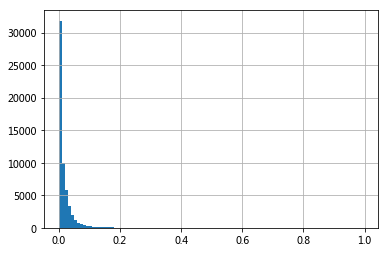

In [150]:
test['predicted_score'].hist(bins=100)

0.020787920749680368

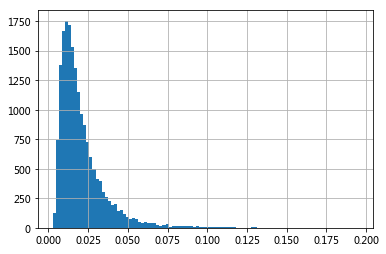

In [80]:
import pandas as pd
a = pd.read_csv("../data/out/rs3.csv",sep=' ')
a['predicted_score'].hist(bins=100)
a['p1'] = 0
a[a['predicted_score']>=0.2]['p1'] = 1
a.groupby('p1').agg(len)
a['predicted_score'].mean()

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


0.017912701271594306

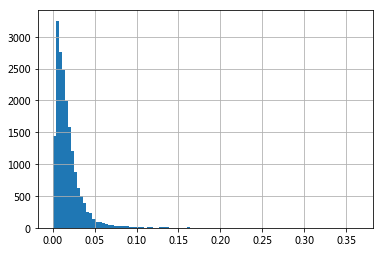

In [79]:
import pandas as pd
a = pd.read_csv("../data/out/rs.csv",sep=' ')
a['predicted_score'].hist(bins=100)
a['p1'] = 0
a[a['predicted_score']>=0.2]['p1'] = 1
a.groupby('p1').agg(len)
a['predicted_score'].mean()

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


instance_id  predicted_score
p1                              
0         18371          18371.0

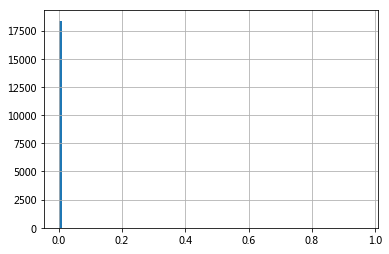

In [72]:
import pandas as pd
a = pd.read_csv("../data/out/rs.csv",sep=' ')
a['predicted_score'].hist(bins=100)
a['p1'] = 0
a[a['predicted_score']>=0.2]['p1'] = 1
a.groupby('p1').agg(len)

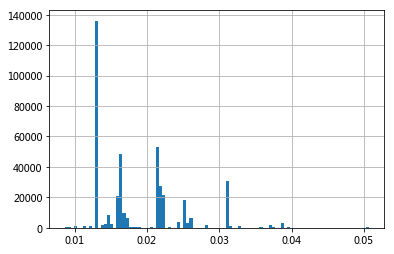

In [75]:
data['item_city_id_pcvr'].hist(bins=100)

In [ ]:
a =get_cache_pcvr

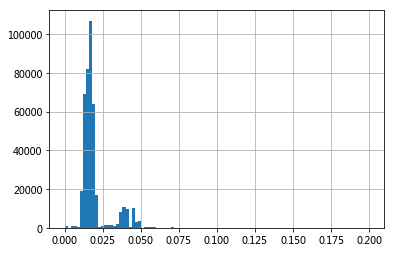

In [76]:
data['user_occupation_id_item_category_1_3d_pcvr'].hist(bins=100)

In [ ]:
data['item_brand_id_pcvr'].hist(bins=100)

In [25]:
data.groupby('context_timestamp_day')[['user_star_level_shop_id_3d_C']].size()

context_timestamp_day
18    78268
19    70931
20    68387
21    71199
22    68318
23    63614
24    57421
25    18371
dtype: int64

In [22]:
[x for x in data.columns if x.startswith('item_id')]

['item_id',
 'item_id_shop_id_count',
 'item_id_1d_C_x',
 'item_id_0d_pcvr_x',
 'item_id_2d_pcvr_x',
 'item_id_1d_pcvr_x',
 'item_id_2d_C_x',
 'item_id_3d_pcvr_x',
 'item_id_2d_I_x',
 'item_id_0d_I_x',
 'item_id_3d_C_x',
 'item_id_1d_I_x',
 'item_id_3d_I_x',
 'item_id_0d_C_x',
 'item_id_3d_I_y',
 'item_id_2d_C_y',
 'item_id_3d_C_y',
 'item_id_0d_pcvr_y',
 'item_id_1d_I_y',
 'item_id_1d_C_y',
 'item_id_2d_I_y',
 'item_id_2d_pcvr_y',
 'item_id_0d_I_y',
 'item_id_0d_C_y',
 'item_id_3d_pcvr_y',
 'item_id_1d_pcvr_y']

In [27]:
data = get_all_data()
data = preprocess(data)
pcvr = get_cache_pcvr()
user_features = get_cache_user_features()
brand_faetures = get_cache_brand_features()
item_features = get_cache_item_features()
category_feature = get_cache_category_features()
shop_feature = get_cache_shop_features()

In [33]:
[x for x in category_feature.columns if x.startswith('item_id')]

['item_id_3d_I',
 'item_id_2d_C',
 'item_id_3d_C',
 'item_id_0d_pcvr',
 'item_id_1d_I',
 'item_id_1d_C',
 'item_id_2d_I',
 'item_id_2d_pcvr',
 'item_id_0d_I',
 'item_id_0d_C',
 'item_id_3d_pcvr',
 'item_id_1d_pcvr']

In [155]:
a = 'item_id_0d_C'
a.find('0d1')

-1

In [2]:
utils.load_pickle(utils.temp_data_path+'shop_feature.plk')

global_index  shop_id_item_category_1_count  \
0                  0                              1   
1                  1                              1   
2                  2                              1   
3                  3                              1   
4                  4                              1   
5                  5                              1   
6                  6                              2   
7                  7                              2   
8                  8                              2   
9                  9                              2   
10                10                              2   
11                11                              2   
12                12                              2   
13                13                              2   
14                14                              2   
15                15                              2   
16                16                              2   
17                17                              2   
18                18                              2   
19                19                              2   
20                20                              2   
21                21                              2   
22                22                              2   
23                23                              2   
24                24                              2   
25                25                              2   
26                26                              2   
27                27                              2   
28                28                              2   
29                29                              3   
...              ...                            ...   
496479        496479                              1   
496480        496480                              2   
496481        496481                              2   
496482        496482                              2   
496483        496483                              2   
496484        496484                              2   
496485        496485                              2   
496486        496486                              2   
496487        496487                              1   
496488        496488                              1   
496489        496489                              1   
496490        496490                              1   
496491        496491                              1   
496492        496492                              1   
496493        496493                              1   
496494        496494                              1   
496495        496495                              2   
496496        496496                              2   
496497        496497                              2   
496498        496498                              2   
496499        496499                              2   
496500        496500                              2   
496501        496501                              1   
496502        496502                              1   
496503        496503                              1   
496504        496504                              1   
496505        496505                              1   
496506        496506                              1   
496507        496507                              1   
496508        496508                              1   

        user_star_level_shop_id_1d_pcvr  user_star_level_shop_id_3d_pcvr  \
0                                   NaN                              NaN   
1                                   NaN                              NaN   
2                                   NaN                              NaN   
3                                   NaN                              NaN   
4                                   NaN                              NaN   
5                                   NaN                              NaN   
6                                   NaN                          

In [8]:
data.columns

Index(['context_id', 'context_page_id', 'context_timestamp', 'instance_id',
       'is_trade', 'item_brand_id', 'item_category_list', 'item_city_id',
       'item_collected_level', 'item_id', 'item_price_level',
       'item_property_list', 'item_pv_level', 'item_sales_level',
       'predict_category_property', 'shop_id', 'shop_review_num_level',
       'shop_review_positive_rate', 'shop_score_delivery',
       'shop_score_description', 'shop_score_service', 'shop_star_level',
       'type', 'user_age_level', 'user_gender_id', 'user_id',
       'user_occupation_id', 'user_star_level', 'global_index',
       'context_timestamp_Hour', 'context_timestamp_weekday',
       'item_category_0', 'item_category_1', 'item_category_2',
       'item_category_1_pcvr', 'item_category_2_pcvr', 'item_brand_id_pcvr',
       'item_city_id_pcvr', 'item_price_level_pcvr', 'item_sales_level_pcvr',
       'item_collected_level_pcvr', 'item_pv_level_pcvr',
       'user_gender_id_pcvr', 'user_age_level_pcvr',

In [38]:
rs = data.groupby(["context_timestamp_weekday",'user_gender_id'])['is_trade'].mean()

In [17]:
utils.load_pickle(utils.temp_data_path+"data.y.plk")

instance_id  is_trade
357103  1294180558417909525       0.0
357104  4988669284857152533       0.0
357105  5378282568284173939       0.0
357106  5217602552450998299       0.0
357107   790758633868253958       0.0
357108  3241062861287565666       0.0
357109  7886198892825192867       0.0
357110  4930668919773659131       0.0
357111  5340757334596881667       0.0
357112  8143615325514204867       0.0
357113  2504882768103604607       0.0
357114  5156050118778146436       0.0
357115  9091894655276811213       0.0
357116  4903724015475754003       0.0
357117   936601521905973293       0.0
357118  6104327357717041489       0.0
357119  4326946760545916858       0.0
357120  8743439559428479109       0.0
357121  6361868181804465057       0.0
357122  5292620890170368283       0.0
357123  3586098433349235161       0.0
357124   198801805222841435       0.0
357125  9141241563098002516       0.0
357126  4911886258370037823       0.0
357127  2441233122194056606       0.0
357128  2105928188099622482       0.0
357129  1629470053772161515       0.0
357130  4694884196472664576       0.0
357131  5196508296701081932       0.0
357132  5971169471453371705       0.0
...                     ...       ...
420687  2394334775720910613       0.0
420688  5537893329655675605       1.0
420689  1351364939274339347       0.0
420690   754246963521291703       0.0
420691  5965690221622731937       0.0
420692  5665020345691245213       0.0
420693  1264416702975224535       1.0
420694  5452666975081583324       0.0
420695  7776510344446252809       0.0
420696  3881742273802591314       0.0
420697  2180475390592777167       0.0
420698  6678677938891559592       0.0
420699  3221376670279941757       0.0
420700  5622235038466537753       0.0
420701  7745789262845760835       0.0
420702  6020346644052860648       0.0
420703  8885308343239353964       0.0
420704  1276598325842108668       0.0
420705  7795912219630980388       0.0
420706  8921903548123227248       0.0
420707  7778635697071497959       0.0
420708  1647909492345395775       0.0
420709    41716769183896606       0.0
420710  7799510086611304240       0.0
420711  5009727150986515268       0.0
420712  6333063971708214505       0.0
420713  4111202822720249343       0.0
420714  1501452626114985167       0.0
420715  1403598391690598470       0.0
420716  2179231811091010753       0.0

[63614 rows x 2 columns]

In [34]:
data['context_timestamp_weekday'].value_counts()

1    96639
4    71199
2    70931
3    68387
5    68318
6    63614
0    57421
Name: context_timestamp_weekday, dtype: int64

In [40]:
[rs.get(d).get(0) for d in range(7)]

[0.016387371539672253,
 0.01939647889703646,
 0.01979957825592028,
 0.019287431185547026,
 0.018868630901126875,
 0.017967105775976305,
 0.016984787896277363]

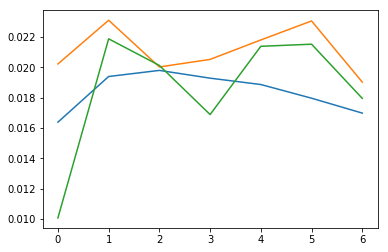

In [43]:
plt.plot([rs.get(d).get(0) for d in range(7)])
plt.plot([rs.get(d).get(1) for d in range(7)])
plt.plot([rs.get(d).get(2) for d in range(7)])

In [4]:
data = preprocess.get_all_data()
data = preprocess.preprocess(data)
train,test = utils.split_train_test(data)

In [3]:
%time
data = get_pcvr(data)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [6]:
data['item_brand_id'] =  pc.LabelEncoder().fit_transform(data['item_brand_id'])

In [7]:
get_pcvr(data,['item_brand_id'])

100%|██████████| 1/1 [00:46<00:00, 46.90s/it]


context_id  context_page_id   context_timestamp  \
0        282924576738839389             4006 2018-09-18 10:09:04   
1       4007979028023783431             4001 2018-09-18 12:00:32   
2       4884875192608989870             4001 2018-09-18 03:04:12   
3        840119421106178602             4016 2018-09-18 06:17:50   
4       1736769971710354684             4001 2018-09-18 19:48:40   
5       4434980272230296456             4003 2018-09-18 23:00:55   
6       3622211816051289512             4001 2018-09-18 22:18:37   
7       7851031132945961016             4001 2018-09-18 16:58:40   
8       8388974876851097582             4001 2018-09-18 02:27:51   
9       1138535512266486347             4003 2018-09-18 23:43:10   
10      1321094267098227649             4001 2018-09-18 17:30:36   
11      3293182224165193298             4001 2018-09-18 11:12:41   
12      2923308860909436591             4001 2018-09-18 23:38:02   
13      1568203150915810671             4003 2018-09-18 22:21:24   
14      7612168924020353960             4001 2018-09-18 14:44:56   
15      6077456298556673177             4001 2018-09-18 00:41:35   
16      4186010745541353720             4001 2018-09-18 18:16:53   
17      2114570907387457012             4001 2018-09-18 15:38:55   
18      2706241160694606116             4001 2018-09-18 18:52:40   
19      2784562050073936754             4001 2018-09-18 21:52:35   
20      4957834265833679305             4001 2018-09-18 22:55:21   
21      1994324784426625461             4001 2018-09-18 22:41:14   
22        21078676648921244             4001 2018-09-18 21:31:21   
23      5339270571413316981             4001 2018-09-18 22:01:15   
24      8745121827546601523             4001 2018-09-18 22:29:14   
25      3057456446029416651             4001 2018-09-18 08:52:46   
26       776761033272814908             4001 2018-09-18 23:37:36   
27      8523910808124381721             4001 2018-09-18 23:48:02   
28      1322881591063873848             4003 2018-09-18 20:22:21   
29       554970489873597054             4010 2018-09-18 09:44:32   
...                     ...              ...                 ...   
496479  6303785551269873951             4001 2018-09-25 18:22:13   
496480    37776136224226750             4008 2018-09-25 14:08:01   
496481  4024770875359748462             4003 2018-09-25 15:58:44   
496482  4571571920114792462             4001 2018-09-25 15:52:57   
496483  6844527136763687471             4003 2018-09-25 14:30:44   
496484  3984861617438085782             4001 2018-09-25 21:48:32   
496485  1774213301723687402             4007 2018-09-25 20:15:01   
496486  2471413658767761432             4002 2018-09-25 16:07:22   
496487  7919460280688873622             4003 2018-09-25 17:29:08   
496488  1676417779345598652             4010 2018-09-25 10:03:03   
496489   419735310253082122             4001 2018-09-25 15:06:15   
496490  2020554390996227172             4009 2018-09-25 14:23:30   
496491  9167007455057446232             4015 2018-09-25 14:26:11   
496492  4263930575474897952             4001 2018-09-25 15:09:47   
496493  4823015982089993641             4002 2018-09-25 18:41:37   
496494  3651384826580558612             4001 2018-09-25 14:41:19   
496495  2190606581652505131             4001 2018-09-25 08:19:24   
496496  8505833002819186470             4001 2018-09-25 10:42:29   
496497  5169741761066096231             4001 2018-09-25 12:29:28   
496498  7603695272483341670             4001 2018-09-25 13:16:35   
496499   463659678296372230             4001 2018-09-25 08:16:13   
496500  7760833483316740720             4009 2018-09-25 13:35:24   
496501  8836179385839263882             4001 2018-09-25 14:37:06   
496502  5874878395395735560             4017 2018-09-25 13:30:21   
496503  8526669506695670732             4002 2018-09-25 19:49:17   
496504  1458471930566331571             4002 2018-09-25 19:24:26   
496505  2719018122599639680             4001 2018-09-25 18:07:39   
49650

In [38]:
len(data['context_id'])

496509

In [9]:
import numpy as np

In [13]:
train_data = data[data['type']=='train']

In [24]:
train_size = int(train_data.size*.8)
index=np.arange(train_data.size) 
np.random.shuffle(index) 
X_train = train_data.loc[index[:train_size]]
X_test = train_data[index[train_size:]]

KeyError: '[31310946 25228678 31770685 ... 11743181 15853812 15709823] not in index'

In [27]:
from sklearn.model_selection import train_test_split

In [37]:
a = data[data['type']=='train'].groupby('item_category_2')

In [39]:
data = get

Index(['context_id', 'context_page_id', 'context_timestamp', 'instance_id',
       'is_trade', 'item_brand_id', 'item_category_list', 'item_city_id',
       'item_collected_level', 'item_id', 'item_price_level',
       'item_property_list', 'item_pv_level', 'item_sales_level',
       'predict_category_property', 'shop_id', 'shop_review_num_level',
       'shop_review_positive_rate', 'shop_score_delivery',
       'shop_score_description', 'shop_score_service', 'shop_star_level',
       'type', 'user_age_level', 'user_gender_id', 'user_id',
       'user_occupation_id', 'user_star_level', 'global_index',
       'context_timestamp_Hour', 'context_timestamp_weekday',
       'item_category_0', 'item_category_1', 'item_category_2',
       'item_category_1_pcvr', 'item_category_2_pcvr', 'item_brand_id_pcvr',
       'item_city_id_pcvr', 'item_price_level_pcvr', 'item_sales_level_pcvr',
       'item_collected_level_pcvr', 'item_pv_level_pcvr',
       'user_gender_id_pcvr', 'user_age_level_pcvr',

In [32]:
test.size

9801870

In [42]:
data[['predict_category_property','item_category_0']]

predict_category_property      item_category_0
0      5799347067982556520:-1;509660095530134768:-1;5...  7908382889764677758
1      5799347067982556520:9172976955054793469;790838...  7908382889764677758
2      5799347067982556520:5131280576272319091;725801...  7908382889764677758
3      509660095530134768:-1;5799347067982556520:-1;7...  7908382889764677758
4      5799347067982556520:9172976955054793469;790838...  7908382889764677758
5      5799347067982556520:9172976955054793469;871073...  7908382889764677758
6      2011981573061447208:7199361004668592209;827733...  7908382889764677758
7      2011981573061447208:7199361004668592209;827733...  7908382889764677758
8      5755694407684602296:-1;5799347067982556520:-1;...  7908382889764677758
9      8277336076276184272:820214312075361939;5096600...  7908382889764677758
10     2011981573061447208:7199361004668592209;827733...  7908382889764677758
11     5799347067982556520:-1;509660095530134768:-1;7...  7908382889764677758
12     8277336076276184272:5131280576272319091,820214...  7908382889764677758
13     8277336076276184272:2636395404473730413,877809...  7908382889764677758
14     4879721024980945592:2636395404473730413,719936...  7908382889764677758
15     8277336076276184272:8778097678320011358;509660...  7908382889764677758
16     5755694407684602296:-1;5799347067982556520:-1;...  7908382889764677758
17     1760164811125093110:2253152183208719552,170013...  7908382889764677758
18     2011981573061447208:7199361004668592209;827733...  7908382889764677758
19     8277336076276184272:820214312075361939;5096600...  7908382889764677758
20     8277336076276184272:116615220158388148;7908382...  7908382889764677758
21     8277336076276184272:820214312075361939;5799347...  7908382889764677758
22     5755694407684602296:-1;5799347067982556520:905...  7908382889764677758
23     1760164811125093110:2253152183208719552,170013...  7908382889764677758
24     1760164811125093110:2253152183208719552,170013...  7908382889764677758
25     1760164811125093110:2253152183208719552,170013...  7908382889764677758
26     8277336076276184272:820214312075361939;5096600...  7908382889764677758
27     5755694407684602296:-1;5799347067982556520:905...  7908382889764677758
28     8277336076276184272:7199361004668592209,820214...  7908382889764677758
29     4879721024980945592:2636395404473730413;581450...  7908382889764677758
...                                                  ...                  ...
18341  509660095530134768:7429744967504106294;8710739...  7908382889764677758
18342  7258015885215914736:-1;7822717283490579102:-1;...  7908382889764677758
18343  7258015885215914736:3609861674619569089;790838...  7908382889764677758
18344  5755694407684602296:2636395404473730413;870939...  7908382889764677758
18345  5755694407684602296:880789391723108122;5096600...  7908382889764677758
18346  8710739180200009128:3163265386149801264;575569...  7908382889764677758
18347  8257512457089702259:-1;5755694407684602296:263...  7908382889764677758
18348  7314150500379498593:-1;5799347067982556520:-1;...  7908382889764677758
18349  8277336076276184272:6538068079754090196,382245...  7908382889764677758
18350  509660095530134768:-1;8277336076276184272:-1;5...  7908382889764677758
18351  8277336076276184272:8778097678320011358;790838...  7908382889764677758
18352  8277336076276184272:-1;509660095530134768:2636...  7908382889764677758
18353  8277336076276184272:3257385717871127564;790838...  7908382889764677758
18354  5755694407684602296:4034352801467268686;201198...  7908382889764677758
18355  4879721024980945592:-1;2436715285093487584:-1;...  7908382889764677758
18356  5755694407684602296:5131280576272319091;790838...  7908382889764677758
18357  5755694407684602296:6538068079754090196;836752...  7908382889764677758
18358  5755694407684602296:6538068079754090196;579934...  7908382889764677758
18359  5755694407684602296:6538068079754090196;579934...  7908382889764677758
18360  5799347067982556520:6538068079754090196;575569

In [37]:
data[data['user_id']==7201324926905945581]['is_trade'].mean()

0.0

In [19]:
data['item_category_2'] = pc.LabelEncoder().fit_transform(data['item_category_2'])

In [21]:
data[data['type']=='test']['context']

0    494401
2      1981
1       127
Name: item_category_2, dtype: int64

In [5]:
data

context_id  context_page_id  context_timestamp  \
0       282924576738839389             4006         1537236544   
1      4007979028023783431             4001         1537243232   
2      4884875192608989870             4001         1537211052   
3       840119421106178602             4016         1537222670   
4      1736769971710354684             4001         1537271320   
5      4434980272230296456             4003         1537282855   
6      3622211816051289512             4001         1537280317   
7      7851031132945961016             4001         1537261120   
8      8388974876851097582             4001         1537208871   
9      1138535512266486347             4003         1537285390   
10     1321094267098227649             4001         1537263036   
11     3293182224165193298             4001         1537240361   
12     2923308860909436591             4001         1537285082   
13     1568203150915810671             4003         1537280484   
14     7612168924020353960             4001         1537253096   
15     6077456298556673177             4001         1537202495   
16     4186010745541353720             4001         1537265813   
17     2114570907387457012             4001         1537256335   
18     2706241160694606116             4001         1537267960   
19     2784562050073936754             4001         1537278755   
20     4957834265833679305             4001         1537282521   
21     1994324784426625461             4001         1537281674   
22       21078676648921244             4001         1537277481   
23     5339270571413316981             4001         1537279275   
24     8745121827546601523             4001         1537280954   
25     3057456446029416651             4001         1537231966   
26      776761033272814908             4001         1537285056   
27     8523910808124381721             4001         1537285682   
28     1322881591063873848             4003         1537273341   
29      554970489873597054             4010         1537235072   
...                    ...              ...                ...   
18341  6303785551269873951             4001         1537870933   
18342    37776136224226750             4008         1537855681   
18343  4024770875359748462             4003         1537862324   
18344  4571571920114792462             4001         1537861977   
18345  6844527136763687471             4003         1537857044   
18346  3984861617438085782             4001         1537883312   
18347  1774213301723687402             4007         1537877701   
18348  2471413658767761432             4002         1537862842   
18349  7919460280688873622             4003         1537867748   
18350  1676417779345598652             4010         1537840983   
18351   419735310253082122             4001         1537859175   
18352  2020554390996227172             4009         1537856610   
18353  9167007455057446232             4015         1537856771   
18354  4263930575474897952             4001         1537859387   
18355  4823015982089993641             4002         1537872097   
18356  3651384826580558612             4001         1537857679   
18357  2190606581652505131             4001         1537834764   
18358  8505833002819186470             4001         1537843349   
18359  5169741761066096231             4001         1537849768   
18360  7603695272483341670             4001         1537852595   
18361   463659678296372230             4001         1537834573   
18362  7760833483316740720             4009         1537853724   
18363  8836179385839263882             4001         1537857426   
18364  5874878395395735560             4017         1537853421   
18365  8526669506695670732             4002         1537876157   
18366  1458471930566331571             4002         1537874666   
18367  2719018122599639680             4001         1537870059   
18368  1183716132149836471             4015         1537864211   
18369   394781106752663382             4001         1537

In [13]:
data

'../data/temp/all_data.plk'

In [31]:
pd.concat([train,test]).count()

context_id                   496509
context_page_id              496509
context_timestamp            496509
context_timestamp_Hour       496509
instance_id                  496509
is_trade                     478138
item_brand_id                496509
item_category_list           496509
item_city_id                 496509
item_collected_level         496509
item_id                      496509
item_price_level             496509
item_property_list           496509
item_pv_level                496509
item_sales_level             496509
predict_category_property    496509
shop_id                      496509
shop_review_num_level        496509
shop_review_positive_rate    496509
shop_score_delivery          496509
shop_score_description       496509
shop_score_service           496509
shop_star_level              496509
user_age_level               496509
user_gender_id               496509
user_id                      496509
user_occupation_id           496509
user_star_level             

In [6]:
a = pd.DataFrame({'a':[1,[1,2,3],[1,2]]})
b= pd.DataFrame({'a':[1,2,3],'b':[1,2,3]})
d = pd.concat([a,b])
d.count()

a    6
b    3
dtype: int64

In [46]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

TypeError: __init__() got an unexpected keyword argument 'sparse'

In [47]:
data = vectorizer.fit_transform(data['item_property_list'])

In [52]:
data.max

<bound method _minmax_mixin.max of <496509x62368 sparse matrix of type '<class 'numpy.int64'>'
	with 16998124 stored elements in Compressed Sparse Row format>>

In [32]:
a = set()
data['item_property_list'].apply(lambda x: a.update(x.split(";")))

0        None
1        None
2        None
3        None
4        None
5        None
6        None
7        None
8        None
9        None
10       None
11       None
12       None
13       None
14       None
15       None
16       None
17       None
18       None
19       None
20       None
21       None
22       None
23       None
24       None
25       None
26       None
27       None
28       None
29       None
         ... 
18341    None
18342    None
18343    None
18344    None
18345    None
18346    None
18347    None
18348    None
18349    None
18350    None
18351    None
18352    None
18353    None
18354    None
18355    None
18356    None
18357    None
18358    None
18359    None
18360    None
18361    None
18362    None
18363    None
18364    None
18365    None
18366    None
18367    None
18368    None
18369    None
18370    None
Name: item_property_list, Length: 496509, dtype: object

In [45]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
enc.fit(pd.Series(list(a)).values.reshape(-1,1))

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

In [42]:
pd.Series(list(a)).values

array(['8471537965555997993', '1072230159137658442',
       '8997247727992679154', ..., '5845988383776626845',
       '6284123159068482235', '809121810727016692'], dtype=object)

In [4]:
train = read_data()
test = read_test_data()
train,test = prepare_train_test(train,test)

KeyboardInterrupt: 

In [5]:
data  = read_data()

NameError: name 'data' is not defined

KeyError: 'category_last'

In [37]:
import os,
reload(os)

ModuleNotFoundError: No module named 'reload'

In [49]:
import xgboost as xgb
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.externals import joblib
import numpy as np
from scipy.sparse import hstack
from sklearn.preprocessing.data import OneHotEncoder
import utils
import preprocess1 as preprocess
from  combineData import get_final_data
from sklearn.metrics import log_loss

In [54]:
all_data = get_final_data()

train,test = utils.get_online_train_test(all_data)

## 列出训练特征
features = []
# 广告相关的特征
features.extend(['item_id', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
            'item_collected_level', 'item_pv_level', 'item_category_0','item_category_1','item_category_2',])
# 用户相关的特征
features.extend(['user_gender_id', 'user_occupation_id','user_age_level', 'user_star_level',])
# 上下文相关的特征
features.extend(['context_page_id','context_timestamp_Hour','context_timestamp_weekday'])
# 店铺相关的特征
features.extend(['shop_id', 'shop_review_num_level', 'shop_star_level',
            'shop_review_positive_rate', 'shop_score_service', 'shop_score_delivery', 'shop_score_description',])
# pcvr特征
features.extend([
            'item_category_1_pcvr','item_category_1_C','item_category_1_I',
            'item_category_2_pcvr','item_category_2_C','item_category_2_I',
            'item_brand_id_pcvr','item_brand_id_C','item_brand_id_I',
            'item_city_id_pcvr','item_city_id_C','item_city_id_I',
            'item_price_level_pcvr','item_price_level_C','item_price_level_I',
            'item_sales_level_pcvr','item_sales_level_C','item_sales_level_I',
            'item_collected_level_pcvr','item_collected_level_C','item_collected_level_I',
            'item_pv_level_pcvr','item_pv_level_C','item_pv_level_I',
            'user_gender_id_pcvr','user_gender_id_C','user_gender_id_I',
            'user_age_level_pcvr','user_age_level_C','user_age_level_I',
            'user_occupation_id_pcvr','user_occupation_id_C','user_occupation_id_I',
            'user_star_level_pcvr','user_star_level_C','user_star_level_I',
            'context_timestamp_Hour_pcvr','context_timestamp_Hour_C','context_timestamp_Hour_I',
            'context_page_id_pcvr','context_page_id_C','context_page_id_I',
            'shop_review_num_level_pcvr','shop_review_num_level_C','shop_review_num_level_I',
            'shop_star_level_pcvr','shop_star_level_C','shop_star_level_I'])

# 定义xgb模型
xgboost = xgb.XGBClassifier(nthread=4, learning_rate=0.08,
                        n_estimators=50, max_depth=5, gamma=0, subsample=0.9, colsample_bytree=0.5)
# 训练xgb学习
xgboost.fit(train[features], train['is_trade'])

# 预测xgb及AUC评测
test['predicted_score'] = xgboost.predict_proba(test[features])[:, 1]
# score = log_loss(test['is_trade'],test['predicted_score'])
# score

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [55]:
# xgboost编码原有特征
X_train_leaves = xgboost.apply(train[features])
X_test_leaves = xgboost.apply(test[features])


# 合并编码后的训练数据和测试数据
All_leaves = np.concatenate((X_train_leaves, X_test_leaves), axis=0)
All_leaves = All_leaves.astype(np.int32)

# 对所有特征进行ont-hot编码
xgbenc = OneHotEncoder()
X_trans = xgbenc.fit_transform(All_leaves)

(train_rows, cols) = X_train_leaves.shape

In [56]:
# 定义LR模型
lr = LogisticRegression()
# lr对xgboost特征编码后的样本模型训练
lr.fit(X_trans[:train_rows, :], train['is_trade'])
# 预测及AUC评测
test['predicted_score'] = lr.predict_proba(X_trans[train_rows:, :])[:, 1]
# score = log_loss(test['is_trade'],test['predicted_score'])
# score

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [57]:
test[['instance_id','predicted_score']].to_csv(utils.result_out_path+'2',sep=" ",index=False)